In [1]:
from spineq.data_fetcher import get_traffic_counts
from spineq.weights import calc_location_weights

import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
traffic_counts = get_traffic_counts()
traffic_counts.head()

,traffic_co,geometry
intn_id,,
intn_0,2605.0,POINT (419953.000 563814.000)
intn_1,2605.0,POINT (420030.000 563786.000)
intn_2,1661.0,POINT (424305.000 563825.000)
intn_3,3807.0,POINT (424086.000 563463.000)
intn_4,3103.0,POINT (424257.000 563483.000)


count      150.000000
mean      1725.886667
std       2445.902648
min          6.000000
25%         94.250000
50%        552.500000
75%       2605.000000
max      13357.000000
Name: traffic_co, dtype: float64

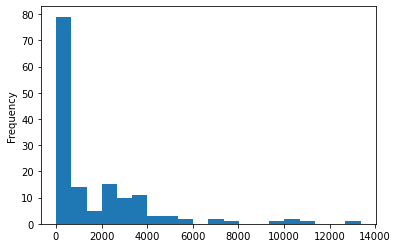

In [3]:
traffic_counts["traffic_co"].plot.hist(bins=20)

traffic_counts["traffic_co"].describe()

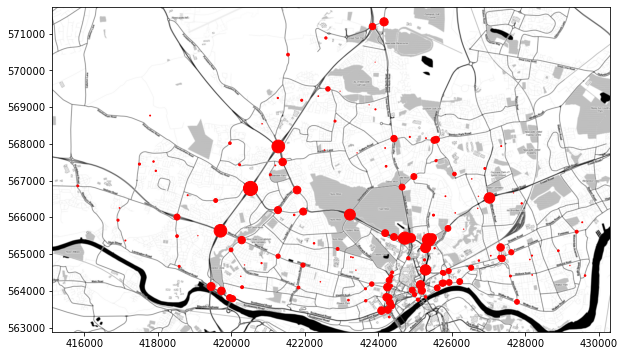

In [4]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
markersize = 200*traffic_counts["traffic_co"]/max(traffic_counts["traffic_co"])
traffic_counts.plot(
    ax=ax,
    markersize=markersize,
    color="r"
)

ctx.add_basemap(
    ax,
    source="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
    crs=traffic_counts.crs.to_epsg()
)

## Traffic intersection counts only optimisation

In [5]:
weights = calc_location_weights(
    population_weight=1,
    workplace_weight=0,
    pop_age_groups={
        "pop_total": {"min": 0, "max": 90, "weight": 1},
        "pop_children": {"min": 0, "max": 16, "weight": 1},
        "pop_elderly": {"min": 70, "max": 90, "weight": 0},
    },
    traffic_weight=1,
    combine=False,
)

In [6]:
traffic_counts = get_traffic_counts()["traffic_co"]
traffic_weight = traffic_counts / traffic_counts.sum()
traffic_weight.name = "traffic"

In [7]:
oa_weight = calc_location_weights(workplace_weight=1, combine=False)
oa_weight

,pop_total,workplace
oa11cd,,
E00042042,0.000989,0.000103
E00042043,0.000970,0.000012
E00042044,0.000785,0.000260
E00042045,0.000642,0.000012
E00042046,0.001353,0.001045
...,...,...
E00175601,0.000447,0.000030
E00175602,0.000766,0.000048
E00175603,0.000919,0.000199


In [8]:
all_weight = oa_weight.join(traffic_weight, how="outer").fillna(0)
all_weight

,pop_total,workplace,traffic
E00042042,0.000989,0.000103,0.000000
E00042043,0.000970,0.000012,0.000000
E00042044,0.000785,0.000260,0.000000
E00042045,0.000642,0.000012,0.000000
E00042046,0.001353,0.001045,0.000000
...,...,...,...
intn_99,0.000000,0.000000,0.009027
intn_990222,0.000000,0.000000,0.000352
intn_990223,0.000000,0.000000,0.000776
intn_990499,0.000000,0.000000,0.001943


In [9]:
oa_weight["poi_type"] = "oa"

traffic_weight = pd.DataFrame(traffic_weight)
traffic_weight["poi_type"] = "intn"

In [10]:
all_weight["poi_type"] = np.nan
all_weight.loc[all_weight.index.isin(oa_weight.index), "poi_type"] = "output_area"
all_weight.loc[all_weight.index.isin(traffic_weight.index), "poi_type"] = "intersection"

all_weight

,pop_total,workplace,traffic,poi_type
E00042042,0.000989,0.000103,0.000000,output_area
E00042043,0.000970,0.000012,0.000000,output_area
E00042044,0.000785,0.000260,0.000000,output_area
E00042045,0.000642,0.000012,0.000000,output_area
E00042046,0.001353,0.001045,0.000000,output_area
...,...,...,...,...
intn_99,0.000000,0.000000,0.009027,intersection
intn_990222,0.000000,0.000000,0.000352,intersection
intn_990223,0.000000,0.000000,0.000776,intersection
intn_990499,0.000000,0.000000,0.001943,intersection


## Space Syntax

In [11]:
p = "/Users/jroberts/Newcastle University/Eman Zied - Spatial Inequality in The Smart City 2021-22/Space Syntax/Newcastle Space Syntax/Newcastle_Analysed.shp"
ss = gpd.read_file(p)
ss

,fid,id,SegID,AI_,AI__N,AI__TD,AI__MD,AC_,AC__NACH,AC__N,AC__TD,AC__MD,geometry
0,1.0,1,1,0.040449,104786,2590537.50,24.722408,0.0,0.000000,104786,2590537.50,24.722408,"LINESTRING (425470.640 582992.090, 425485.890 ..."
1,2.0,2,1,0.040451,104786,2590448.75,24.721561,209568.0,0.829723,104786,2590448.75,24.721561,"LINESTRING (425485.890 582988.740, 425489.920 ..."
2,3.0,3,1,0.040451,104786,2590389.50,24.720995,419132.0,0.876662,104786,2590389.50,24.720995,"LINESTRING (425489.920 582987.860, 425500.000 ..."
3,4.0,4,1,0.040452,104786,2590351.25,24.720630,628692.0,0.904119,104786,2590351.25,24.720630,"LINESTRING (425500.000 582985.650, 425513.010 ..."
4,5.0,5,1,0.040453,104786,2590311.75,24.720253,838248.0,0.923600,104786,2590311.75,24.720253,"LINESTRING (425513.010 582982.790, 425543.750 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104781,104893.0,104893,33329,0.041157,104786,2546010.00,24.297466,2096397.0,0.986827,104786,2546010.00,24.297466,"LINESTRING (411692.200 562093.400, 411704.600 ..."
104782,104894.0,104894,33329,0.041848,104786,2503931.75,23.895899,2301617.0,0.994282,104786,2503931.75,23.895899,"LINESTRING (411704.600 562106.200, 411790.460 ..."
104783,104895.0,104895,33329,0.041848,104786,2503924.00,23.895825,2507777.0,1.000104,104786,2503924.00,23.895825,"LINESTRING (411790.460 562119.660, 411799.000 ..."
104784,104896.0,104896,33329,0.042356,104786,2473887.25,23.609174,2713997.0,1.006292,104786,2473887.25,23.609174,"LINESTRING (411799.000 562121.000, 411826.000 ..."


(406369.1167578125, 434080.6132421875, 560276.3063867188, 584617.4136132812)

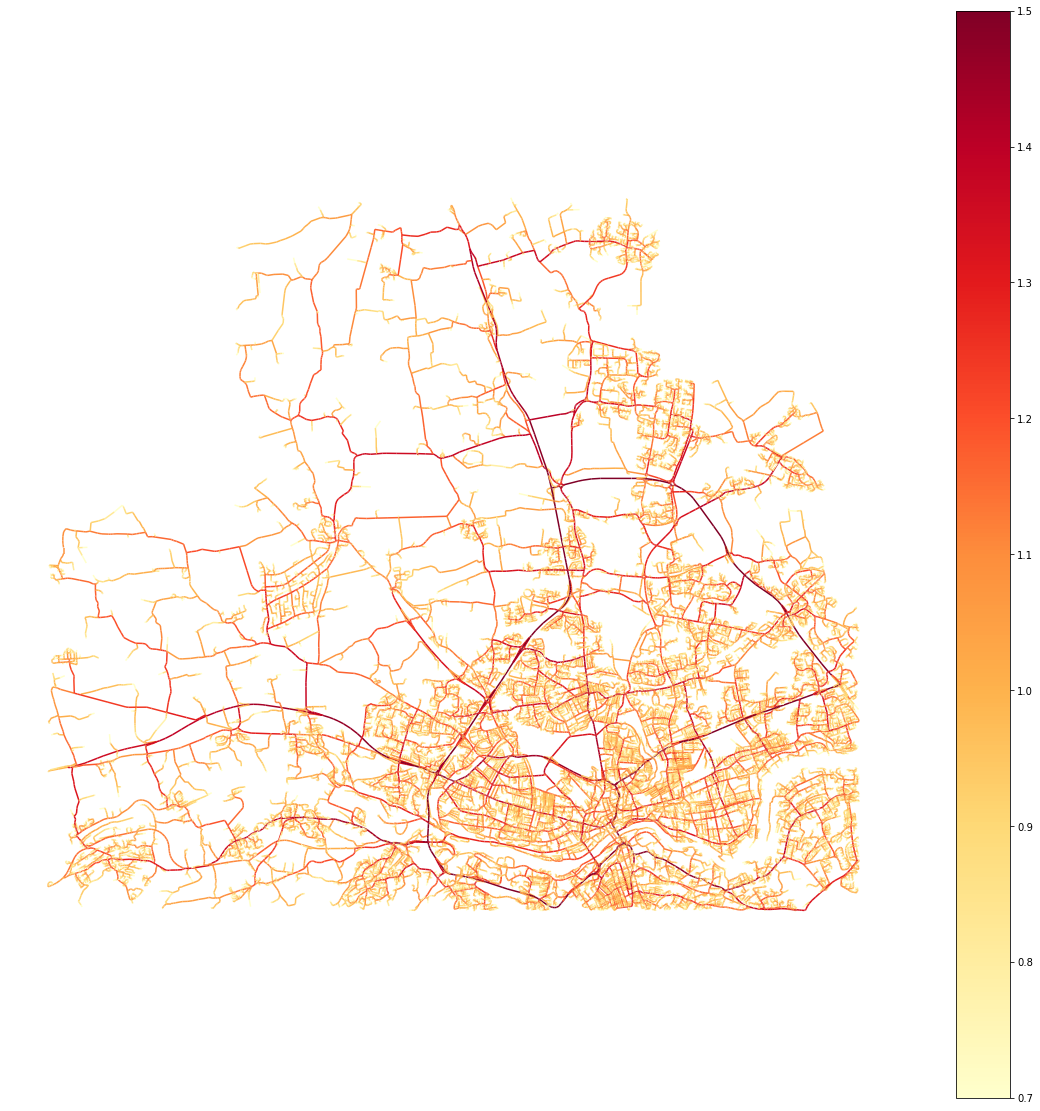

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ss.plot(column="AC__NACH", ax=ax, cmap="YlOrRd", legend=True, vmin=0.7, vmax=1.5)
ax.axis("off")


<AxesSubplot:ylabel='Frequency'>

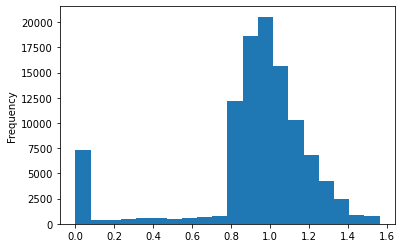

In [13]:
ss["AC__NACH"].plot.hist(bins=20)

## Raw DFT Traffic Data

In [14]:
dft = pd.read_csv("../data/raw/raw_dft_data/dft_aadf_local_authority_id_172.csv")
dft.head()

,count_point_id,year,region_id,region_name,local_authority_id,local_authority_name,road_name,road_type,start_junction_road_name,end_junction_road_name,...,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles
0,46650,2019,11,North East,172,Newcastle upon Tyne,A191,Major,A1(T)/A69,B1311,...,93,1063,77,9,16,0,1,2,104,8358
1,6745,2019,11,North East,172,Newcastle upon Tyne,A193,Major,A193/A167(M),A193,...,76,2959,157,26,17,9,20,12,240,21292
2,6740,2019,11,North East,172,Newcastle upon Tyne,A191,Major,A189,A188,...,174,1843,80,8,9,3,3,9,113,14107
3,38720,2019,11,North East,172,Newcastle upon Tyne,A1,Major,Kingston Park Road roundabout,A1056 North Brunton,...,140,12151,1075,236,450,119,906,947,3733,85837
4,37534,2019,11,North East,172,Newcastle upon Tyne,A186,Major,Clayton St West,Collingwood St,...,777,587,83,12,5,7,5,5,116,6864


In [15]:
select_year = 2019
dft = dft[dft["year"] == select_year]
dft.head()

,count_point_id,year,region_id,region_name,local_authority_id,local_authority_name,road_name,road_type,start_junction_road_name,end_junction_road_name,...,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles
0,46650,2019,11,North East,172,Newcastle upon Tyne,A191,Major,A1(T)/A69,B1311,...,93,1063,77,9,16,0,1,2,104,8358
1,6745,2019,11,North East,172,Newcastle upon Tyne,A193,Major,A193/A167(M),A193,...,76,2959,157,26,17,9,20,12,240,21292
2,6740,2019,11,North East,172,Newcastle upon Tyne,A191,Major,A189,A188,...,174,1843,80,8,9,3,3,9,113,14107
3,38720,2019,11,North East,172,Newcastle upon Tyne,A1,Major,Kingston Park Road roundabout,A1056 North Brunton,...,140,12151,1075,236,450,119,906,947,3733,85837
4,37534,2019,11,North East,172,Newcastle upon Tyne,A186,Major,Clayton St West,Collingwood St,...,777,587,83,12,5,7,5,5,116,6864


In [16]:
dft = gpd.GeoDataFrame(dft, geometry=gpd.points_from_xy(dft["easting"], dft["northing"]),  crs="epsg:27700")

(406369.1167578125, 434080.6132421875, 560276.3063867188, 584617.4136132812)

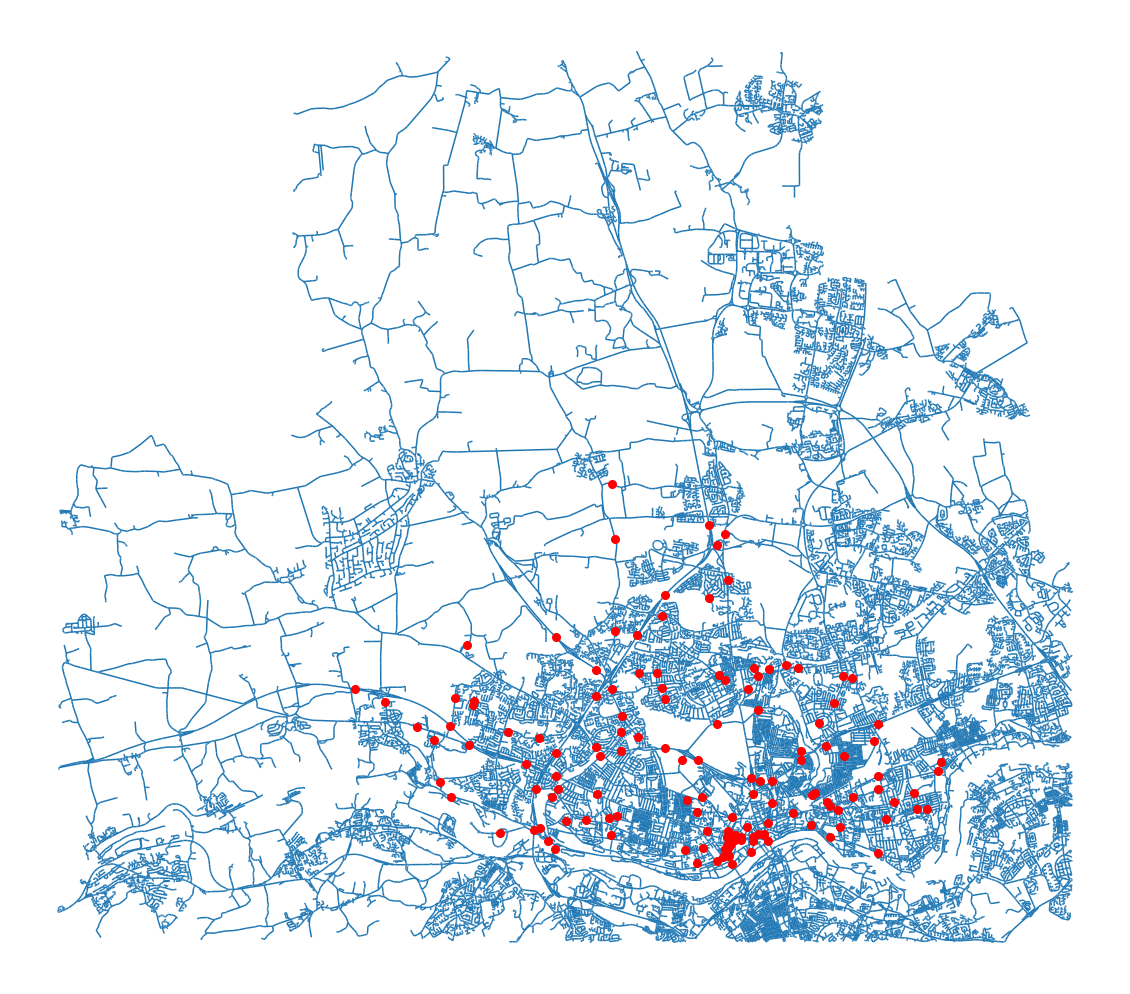

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ss.plot(ax=ax, zorder=1)
dft.plot(ax=ax, markersize=64, color="r", zorder=2)
ax.axis("off")

### Snap DFT points to nearest  lines (roads) in space syntax model

Following approach from:
- https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa


In [18]:
# Create spatial index:
ss.sindex

rtree.index.Index(bounds=[407628.730234375, 561382.7203515625, 432820.999765625, 583510.9996484375], size=104786)

In [19]:
offset = 10
bbox = dft.bounds + [-offset, -offset, offset, offset]
bbox

,minx,miny,maxx,maxy
0,419890.0,564990.0,419910.0,565010.0
1,426990.0,564660.0,427010.0,564680.0
2,425990.0,568190.0,426010.0,568210.0
3,422690.0,569990.0,422710.0,570010.0
4,424590.0,563900.0,424610.0,563920.0
...,...,...,...,...
2211,423790.0,571740.0,423810.0,571760.0
2212,424345.0,563315.0,424365.0,563335.0
2213,414990.0,567665.0,415010.0,567685.0
2229,424990.0,567130.0,425010.0,567150.0


In [20]:
hits = bbox.apply(lambda row: list(ss.sindex.intersection(row)), axis=1)
hits

0                                   [68856]
1                     [62817, 62746, 62745]
2                                   [37123]
3                                   [22756]
4                            [78512, 78511]
                       ...                 
2211                                [15476]
2212    [82239, 82325, 82326, 82327, 82222]
2213                                [50869]
2229                                [39142]
2230                                [79452]
Length: 137, dtype: object

In [21]:
import pandas as pd
import numpy as np
tmp = pd.DataFrame({
    # index of points table
    "pt_idx": np.repeat(hits.index, hits.apply(len)),
    # ordinal position of line - access via iloc later
    "line_i": np.concatenate(hits.values)
})
tmp

,pt_idx,line_i
0,0,68856
1,1,62817
2,1,62746
3,1,62745
4,2,37123
...,...,...
304,2212,82327
305,2212,82222
306,2213,50869
307,2229,39142


In [22]:
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(ss.reset_index(drop=True), on="line_i")
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(dft.geometry.rename("point"), on="pt_idx")
# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(tmp, geometry="geometry", crs=dft.crs)
tmp.head()

,pt_idx,line_i,fid,id,SegID,AI_,AI__N,AI__TD,AI__MD,AC_,AC__NACH,AC__N,AC__TD,AC__MD,geometry,point
0,0,68856,68911.0,68911,21842,0.076951,104786,1361710.000,12.995276,55811708.0,1.262898,104786,1361710.000,12.995276,"LINESTRING (419927.000 565036.000, 419849.720 ...",POINT (419900.000 565000.000)
1,1,62817,62872.0,62872,19690,0.053994,104786,1940683.375,18.520622,1401620.0,0.977525,104786,1940683.375,18.520622,"LINESTRING (426963.000 564648.000, 427032.000 ...",POINT (427000.000 564670.000)
2,1,62746,62801.0,62801,19669,0.057254,104786,1830165.750,17.465914,2433473.5,1.019758,104786,1830165.750,17.465914,"LINESTRING (427007.720 564674.830, 426879.000 ...",POINT (427000.000 564670.000)
3,1,62745,62800.0,62800,19669,0.057254,104786,1830166.500,17.465921,2393214.5,1.018601,104786,1830166.500,17.465921,"LINESTRING (427012.580 564676.070, 427007.720 ...",POINT (427000.000 564670.000)
4,2,37123,37162.0,37162,11465,0.067958,104786,1541902.125,14.714913,259914464.0,1.359850,104786,1541902.125,14.714913,"LINESTRING (426019.250 568203.220, 425969.430 ...",POINT (426000.000 568200.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,2212,82327,82394.0,82394,26187,0.072725,104786,1440837.500,13.750418,4256552.0,1.076388,104786,1440837.500,13.750418,"LINESTRING (424361.500 563326.510, 424368.000 ...",POINT (424355.000 563325.000)
305,2212,82222,82289.0,82289,26167,0.077918,104786,1344804.250,12.833939,209688080.0,1.357813,104786,1344804.250,12.833939,"LINESTRING (424368.000 563329.000, 424327.940 ...",POINT (424355.000 563325.000)
306,2213,50869,50908.0,50908,15639,0.073893,104786,1418068.500,13.533125,702698496.0,1.438102,104786,1418068.500,13.533125,"LINESTRING (415138.720 567643.720, 414906.730 ...",POINT (415000.000 567675.000)
307,2229,39142,39181.0,39181,12154,0.075709,104786,1384040.000,13.208379,130645512.0,1.321592,104786,1384040.000,13.208379,"LINESTRING (424966.000 567111.000, 425023.500 ...",POINT (425000.000 567140.000)


In [27]:
tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))
tmp["snap_dist"].describe()

0     7.913170
1    11.947778
2     2.772480
3     9.106540
4     5.297804
Name: snap_dist, dtype: float64

In [29]:
# Discard any lines that are greater than tolerance from points
tolerance = 50
tmp = tmp.loc[tmp.snap_dist <= tolerance]
# Sort on ascending snap distance, so that closest goes to top
tmp = tmp.sort_values(by=["snap_dist"])
tmp

,pt_idx,line_i,fid,id,SegID,AI_,AI__N,AI__TD,AI__MD,AC_,AC__NACH,AC__N,AC__TD,AC__MD,geometry,point,snap_dist
222,411,44157,44196.0,44196,13794,0.056557,104786,1852745.500,17.681400,1.676432e+06,0.993071,104786,1852745.500,17.681400,"LINESTRING (418809.000 566603.000, 418823.000 ...",POINT (418809.000 566603.000),0.000134
223,411,44156,44195.0,44195,13794,0.056557,104786,1852745.500,17.681400,1.466892e+06,0.983819,104786,1852745.500,17.681400,"LINESTRING (418795.000 566607.000, 418809.000 ...",POINT (418809.000 566603.000),0.000137
272,523,63568,63623.0,63623,19939,0.055782,104786,1878485.000,17.927041,2.527890e+05,0.861161,104786,1878485.000,17.927041,"LINESTRING (428186.000 564433.000, 428191.000 ...",POINT (428186.000 564433.000),0.000212
273,523,63567,63622.0,63622,19939,0.055782,104786,1878485.000,17.927041,4.981500e+04,0.748727,104786,1878485.000,17.927041,"LINESTRING (428181.000 564467.000, 428186.000 ...",POINT (428186.000 564433.000),0.000271
242,432,82807,82874.0,82874,26339,0.069056,104786,1517388.500,14.480971,5.380254e+07,1.250717,104786,1517388.500,14.480971,"LINESTRING (423656.000 563730.000, 423703.000 ...",POINT (423656.000 563730.000),0.000320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,120,41024,41063.0,41063,12789,0.053802,104786,1947612.000,18.586744,1.105620e+05,0.801909,104786,1947612.000,18.586744,"LINESTRING (421050.000 566237.000, 421000.490 ...",POINT (421000.000 566230.000),26.219367
107,109,69224,69279.0,69279,21959,0.066137,104786,1584373.750,15.120234,4.191320e+05,0.906852,104786,1584373.750,15.120234,"LINESTRING (426040.000 565898.000, 426071.160 ...",POINT (426071.000 565896.000),27.659064
13,6,67709,67764.0,67764,21444,0.074651,104786,1403669.750,13.395713,1.089305e+07,1.144761,104786,1403669.750,13.395713,"LINESTRING (419473.520 565199.520, 419493.100 ...",POINT (419500.000 565190.000),28.095649
253,480,62776,62831.0,62831,19676,0.060312,104786,1737388.125,16.580504,4.250866e+04,0.741757,104786,1737388.125,16.580504,"LINESTRING (426805.000 564744.500, 426871.000 ...",POINT (426797.000 564772.000),28.639810


In [30]:
# group by the index of the points and take the first, which is the
# closest line 
closest = tmp.groupby("pt_idx").first()
# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")
closest

,line_i,fid,id,SegID,AI_,AI__N,AI__TD,AI__MD,AC_,AC__NACH,AC__N,AC__TD,AC__MD,geometry,point,snap_dist
pt_idx,,,,,,,,,,,,,,,,
0,68856,68911.0,68911,21842,0.076951,104786,1361710.000,12.995276,5.581171e+07,1.262898,104786,1361710.000,12.995276,"LINESTRING (419927.000 565036.000, 419849.720 ...",POINT (419900.000 565000.000),7.913170
1,62746,62801.0,62801,19669,0.057254,104786,1830165.750,17.465914,2.433474e+06,1.019758,104786,1830165.750,17.465914,"LINESTRING (427007.720 564674.830, 426879.000 ...",POINT (427000.000 564670.000),2.772480
2,37123,37162.0,37162,11465,0.067958,104786,1541902.125,14.714913,2.599145e+08,1.359850,104786,1541902.125,14.714913,"LINESTRING (426019.250 568203.220, 425969.430 ...",POINT (426000.000 568200.000),5.297804
3,22756,22795.0,22795,6747,0.087669,104786,1195233.500,11.406532,2.708388e+09,1.552083,104786,1195233.500,11.406532,"LINESTRING (422774.440 570080.890, 422650.880 ...",POINT (422700.000 570000.000),4.231625
4,78512,78579.0,78579,24941,0.074670,104786,1403301.750,13.392201,5.400781e+07,1.257893,104786,1403301.750,13.392201,"LINESTRING (424609.120 563909.890, 424569.350 ...",POINT (424600.000 563910.000),2.717567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,15476,15511.0,15511,4563,0.086012,104786,1218261.875,11.626300,2.545294e+09,1.545537,104786,1218261.875,11.626300,"LINESTRING (423789.780 571806.850, 423818.420 ...",POINT (423800.000 571750.000),0.838068
2212,82326,82393.0,82393,26187,0.072722,104786,1440894.875,13.750965,4.047264e+06,1.072829,104786,1440894.875,13.750965,"LINESTRING (424351.000 563322.500, 424361.500 ...",POINT (424355.000 563325.000),0.908349
2213,50869,50908.0,50908,15639,0.073893,104786,1418068.500,13.533125,7.026985e+08,1.438102,104786,1418068.500,13.533125,"LINESTRING (415138.720 567643.720, 414906.730 ...",POINT (415000.000 567675.000),7.599770


<AxesSubplot:>

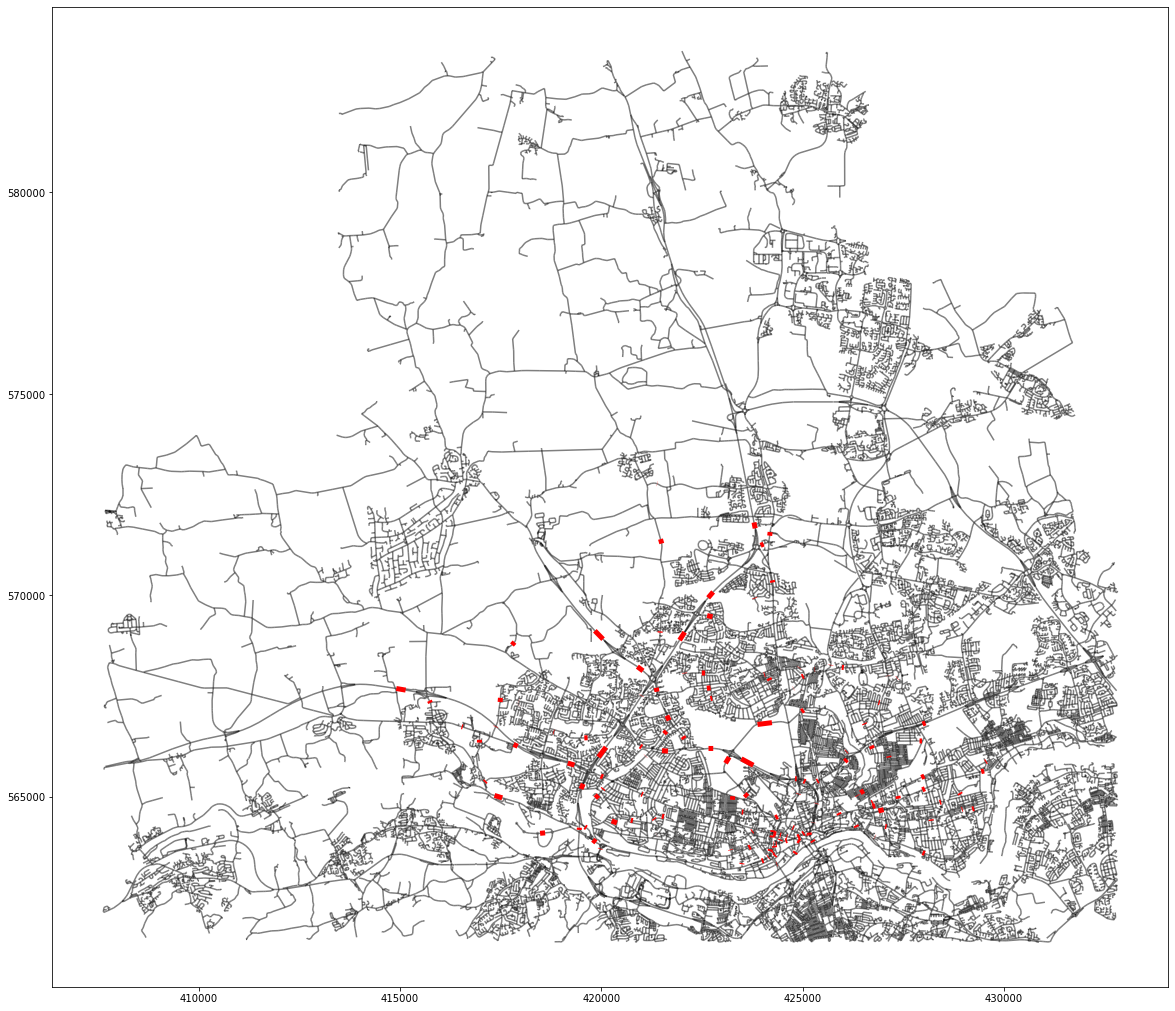

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ss.plot(ax=ax, zorder=1, alpha=0.5, color="k")
closest.plot(ax=ax, zorder=2, color="r", linewidth=5)
#dft.plot(ax=ax, zorder=3)
#closest.iloc[0]["point"].plot(ax=ax, zorder=3, color="r", markersize=20)

Text(0, 0.5, 'log[all_motor_vehicles]')

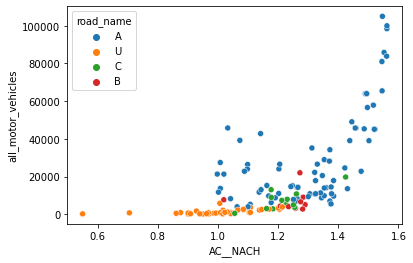

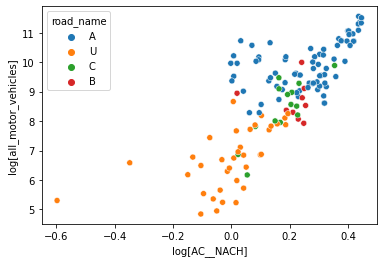

In [152]:
import seaborn as sns

column = "AC__NACH"

plt.figure()
sns.scatterplot(x=closest[column], y=dft["all_motor_vehicles"], hue=dft["road_name"].str[0])
plt.figure()
sns.scatterplot(x=np.log(closest[column]), y=np.log(dft["all_motor_vehicles"]), hue=dft["road_name"].str[0])
plt.xlabel(f"log[{column}]")
plt.ylabel("log[all_motor_vehicles]")

0       A
1       A
2       A
3       A
4       A
       ..
2211    A
2212    A
2213    A
2229    A
2230    A
Name: road_name, Length: 137, dtype: object

In [104]:
print(np.corrcoef(closest["AC__NACH"], dft["all_motor_vehicles"]))

from scipy.stats import spearmanr
spearmanr(closest["AC__NACH"], dft["all_motor_vehicles"])

[[1.         0.67513373]
 [0.67513373 1.        ]]


SpearmanrResult(correlation=0.734746073292606, pvalue=1.632175584180499e-24)

In [77]:
from sklearn.linear_model import LinearRegression

7.535462013064182 [7.34026966]


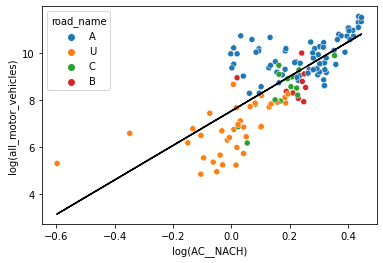

In [149]:
X = np.log(closest["AC__NACH"]).values
y = np.log(dft["all_motor_vehicles"])

mdl = LinearRegression()
mdl.fit(X.reshape(-1, 1), y)
print(mdl.intercept_, mdl.coef_)

y_pred = mdl.predict(X.reshape(-1, 1))
plt.plot(X, y_pred, "k")
sns.scatterplot(x=X, y=y, hue=dft["road_name"].str[0])
plt.xlabel("log(AC__NACH)")
plt.ylabel("log(all_motor_vehicles)")

resid = y_pred - y
closest["resid"] = resid
dft["resid"] = resid
dft["pred"] = np.exp(y_pred)


In [147]:
dft["abs_resid"] = dft["resid"].abs()

print("PRED (SYNTAX) > ACTUAL (DFT)")
display(dft.sort_values(by="resid", ascending=False)[
    ["road_name", "road_type", "all_motor_vehicles", "pred", "resid"]
].head(15))

print("PRED (SYNTAX) < ACTUAL (DFT)")
display(dft.sort_values(by="resid", ascending=True)[
    ["road_name", "road_type", "all_motor_vehicles", "pred", "resid"]
].head(15))

PRED (SYNTAX) > ACTUAL (DFT)


,road_name,road_type,all_motor_vehicles,pred,resid
509,U,Minor,187,2103.021196,2.420022
433,U,Minor,141,1295.220476,2.217676
400,U,Minor,306,2546.385249,2.118845
122,U,Minor,189,1499.762995,2.071315
123,U,Minor,127,867.142324,1.921016
486,C,Minor,479,2789.924931,1.762069
510,U,Minor,212,1185.436069,1.721280
125,U,Minor,396,2147.959118,1.690859
475,U,Minor,286,1411.268926,1.596253
200,U,Minor,625,2716.126498,1.469210


PRED (SYNTAX) < ACTUAL (DFT)


,road_name,road_type,all_motor_vehicles,pred,resid
1891,A695,Major,45770,2369.638055,-2.960892
9,A167,Major,27443,1980.678675,-2.628672
2212,A189,Major,39208,3138.429950,-2.525158
105,A695,Major,21314,1843.371850,-2.447768
1,A193,Major,21292,2162.626062,-2.287008
101,A191,Major,42793,4954.478453,-2.156083
126,U,Minor,201,23.309282,-2.154453
17,A1056,Major,26404,3735.859713,-1.955538
34,A186,Major,13712,1986.629121,-1.931832
119,A1056,Major,22798,3480.900127,-1.879382


(406369.1167578125, 434080.6132421875, 560276.3063867188, 584617.4136132812)

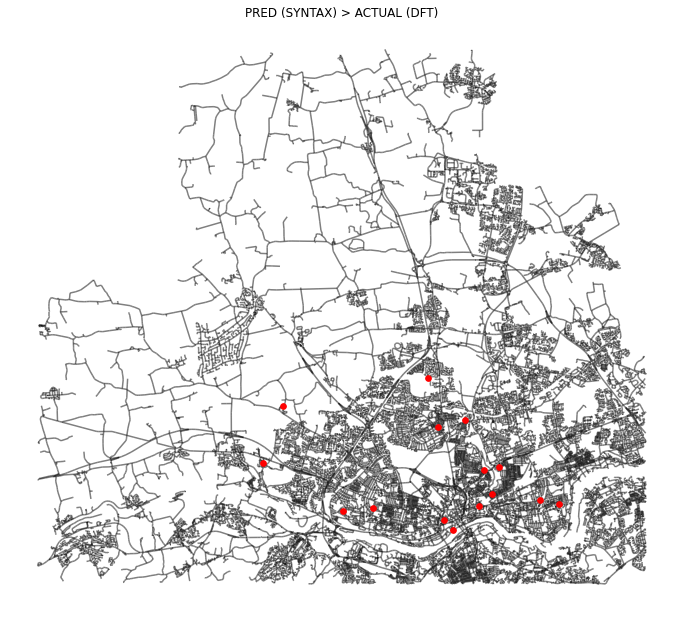

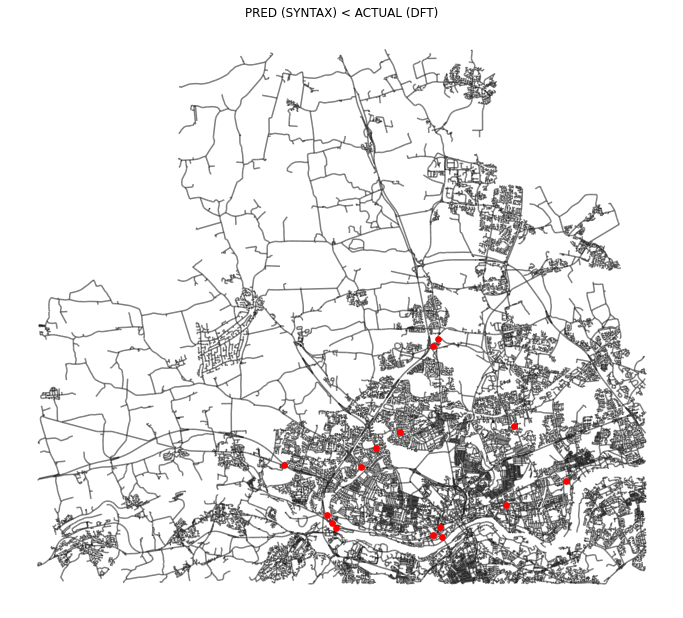

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ss.plot(ax=ax, zorder=1, alpha=0.5, color="k")
dft.sort_values(by="resid", ascending=False).head(15).plot(
    ax=ax, zorder=2, color="r", markersize=32
)
ax.set_title("PRED (SYNTAX) > ACTUAL (DFT)")
ax.axis("off")

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ss.plot(ax=ax, zorder=1, alpha=0.5, color="k")
dft.sort_values(by="resid", ascending=True).head(15).plot(
    ax=ax, zorder=2, color="r", markersize=32
)
ax.set_title("PRED (SYNTAX) < ACTUAL (DFT)")
ax.axis("off")


In [56]:
dft["all_motor_vehicles"].describe()

count       137.000000
mean      17928.890511
std       22719.408717
min         127.000000
25%        2714.000000
50%        9343.000000
75%       22798.000000
max      104999.000000
Name: all_motor_vehicles, dtype: float64

In [65]:
dft.columns

Index(['count_point_id', 'year', 'region_id', 'region_name',
       'local_authority_id', 'local_authority_name', 'road_name', 'road_type',
       'start_junction_road_name', 'end_junction_road_name', 'easting',
       'northing', 'latitude', 'longitude', 'link_length_km',
       'link_length_miles', 'estimation_method', 'estimation_method_detailed',
       'pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis',
       'buses_and_coaches', 'lgvs', 'hgvs_2_rigid_axle', 'hgvs_3_rigid_axle',
       'hgvs_4_or_more_rigid_axle', 'hgvs_3_or_4_articulated_axle',
       'hgvs_5_articulated_axle', 'hgvs_6_articulated_axle', 'all_hgvs',
       'all_motor_vehicles', 'geometry'],
      dtype='object')

In [74]:
import sklearn

ModuleNotFoundError: No module named 'sklearn'